In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
import optax

from cc.collect import *
from cc import save, load
from cc.controller import create_pi_controller, LinearController, LinearControllerOptions
from cc.env.model_based_env import ModelBasedEnv
from cc.env.wrappers import AddReferenceObservationWrapper, RecordVideoWrapper
from cc.env import make_env
from cc.train import TrainingOptionsController, train_controller
from cc.utils.utils import generate_ts, extract_timelimit_timestep_from_env
from cc.controller import NonlinearController, NonlinearControllerOptions
import pprint
import numpy
import jax.random as jrand

In [8]:
time_limit = 10.0
control_timestep = 0.01
ts = generate_ts(time_limit, control_timestep)

# Environment creation
env = make_env("two_segments_v1", random=1, time_limit=time_limit,
               control_timestep=control_timestep)

# Model Loading
model = load("../docs/model_for_two_segments_v1.pkl")
source = collect_reference_source(
    env, seeds=[20], constant_after=True, constant_after_T=3.0)

In [9]:
def get_controller(depth = 1, width = 10):
    # Training
    controller = NonlinearController(
        NonlinearControllerOptions(
        5, 2, 1, # now 2 inputs because of reference and observation are both 1-dimensional
        "EE", jrand.PRNGKey(1,), depth_f=depth, width_f=width
        )
    )

    training_options = TrainingOptionsController(
        optax.adam(3e-3), 0.0, 3000, 1, models=[model]
    )

    
    controller, losses = train_controller(controller, source, training_options)
    return controller, f"depth: {depth} width: {width}"

In [10]:
controllers = []
controllers.append(get_controller())

pp = pprint.PrettyPrinter(indent=4)
numpy.set_printoptions(threshold=5)


Trainings-Loss:     8.0531 | ParamsRegu:     0.0459: 100%|████████████████████████████████████████████████████████████████████| 3000/3000 [00:18<00:00, 162.01it/s]


In [11]:
for p in range(1, 12, 5):
    for i in range(5, 16, 5):
        controllers.append(get_controller(p, i))

Trainings-Loss:     4.2237 | ParamsRegu:     0.0529: 100%|████████████████████████████████████████████████████████████████████| 3000/3000 [00:17<00:00, 167.94it/s]
Trainings-Loss:     8.0531 | ParamsRegu:     0.0459: 100%|████████████████████████████████████████████████████████████████████| 3000/3000 [00:17<00:00, 166.89it/s]
Trainings-Loss:     1.8965 | ParamsRegu:     0.0527: 100%|████████████████████████████████████████████████████████████████████| 3000/3000 [00:19<00:00, 151.09it/s]
Trainings-Loss:     7.0017 | ParamsRegu:     0.1381: 100%|████████████████████████████████████████████████████████████████████| 3000/3000 [00:28<00:00, 107.11it/s]
Trainings-Loss:     4.0245 | ParamsRegu:     0.0510: 100%|█████████████████████████████████████████████████████████████████████| 3000/3000 [00:31<00:00, 96.24it/s]
Trainings-Loss:     2.6043 | ParamsRegu:     0.0413: 100%|█████████████████████████████████████████████████████████████████████| 3000/3000 [00:36<00:00, 81.59it/s]
Trainings-Loss: 

In [12]:
time_limit, control_timestep, ts = extract_timelimit_timestep_from_env(env)

#real_env_w_source = ModelBasedEnv(env, model, time_limit=time_limit, control_timestep=control_timestep) # <--- collect 
env_with_ref = AddReferenceObservationWrapper(env, source)
result = collect_multiple(env, source, [c[0] for c in controllers])

result_ranked = sorted(enumerate(result.obs["obs"]["xpos_of_segment_end"]), key=lambda x: result.extras["aggr_rew"][x[0]])


<IPython.core.display.Javascript object>


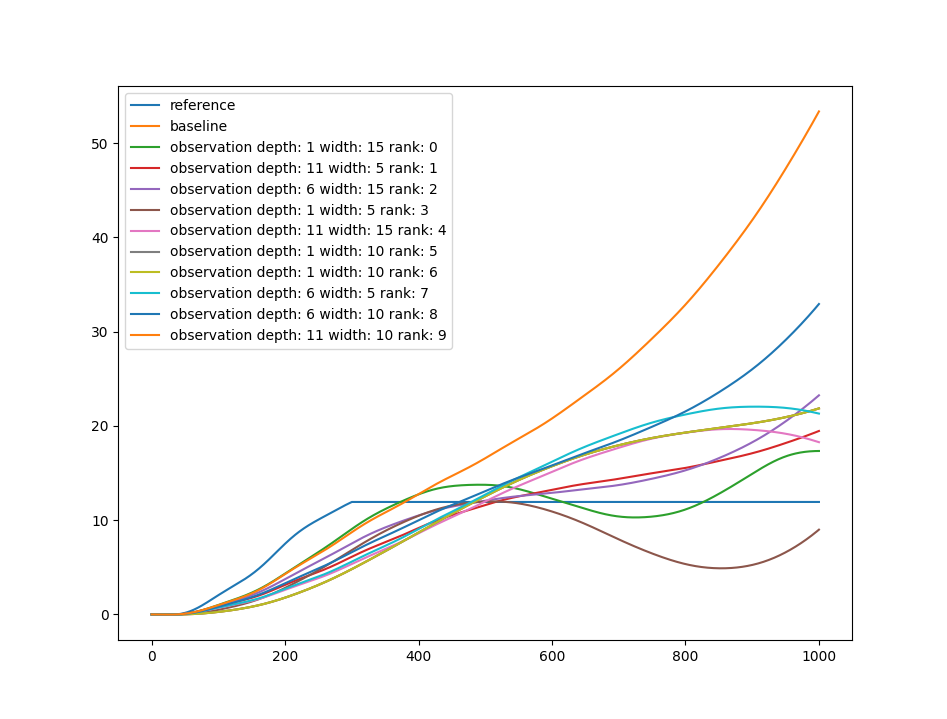

31321.133
0: 4873.37255859375
1: 13171.78515625
2: 14283.9912109375
3: 16100.72265625
4: 25552.693359375
0: 31321.1328125
1: 31321.1328125
2: 37657.4765625
3: 59133.9140625
4: 243313.609375


In [13]:
plt.plot(result.obs["ref"]
         ["xpos_of_segment_end"][0], label="reference")
plt.plot(result.obs["obs"]
         ["xpos_of_segment_end"][0], label="baseline")
print(numpy.sum(numpy.abs(result.extras["aggr_rew"][0])))

for rank, (index, value) in enumerate(result_ranked[:5]):
    print(f"{rank}: {result.extras['aggr_rew'][index]}")
    plt.plot(value, label=f"observation {controllers[index][1]} rank: {rank}")

for rank, (index, value) in enumerate(result_ranked[-5:]):
    print(f"{rank}: {result.extras['aggr_rew'][index]}")
    plt.plot(value, label=f"observation {controllers[index][1]} rank: {len(result_ranked) - 5 + rank}")

plt.legend()
plt.show()